In [10]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier

### 1. Data preprocessing & feature engineering

In [11]:
base_path = "./DataBase"
group_paths = {
    'Group_A': os.path.join(base_path, "SETA"),
    'Group_B': os.path.join(base_path, "SETB"),
    'Group_C': os.path.join(base_path, "SETC"),
    'Group_D': os.path.join(base_path, "SETD")
}

In [12]:
bands = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (12, 30)
}
sampling_frequency = 100

In [13]:
# Function to apply a bandpass filter
def bandpass_filter(data, lowcut, highcut, fs, order=4, padlen=10):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0, padlen=padlen)

In [14]:
# Function to compute power in each band
def compute_band_power(df, band, fs):
    low, high = bands[band]
    filtered_data = bandpass_filter(df.values, low, high, fs=fs)
    band_power = np.mean(filtered_data ** 2, axis=0) 
    return band_power.mean()  

In [15]:
# Function to process all files in a group
def process_group_data(group_name, group_path):
    files = [os.path.join(group_path, f) for f in os.listdir(group_path) if f.endswith('.out')]
    group_data = []
    for file in files:
        df = pd.read_csv(file, delim_whitespace=True, header=None)
        features = {f"{band}_power": compute_band_power(df, band, sampling_frequency) for band in bands}
        features['Group'] = group_name
        group_data.append(features)
    return pd.DataFrame(group_data)

In [16]:
# Load and process all groups
all_data = pd.DataFrame()
for group_name, group_path in group_paths.items():
    group_data = process_group_data(group_name, group_path)
    all_data = pd.concat([all_data, group_data], ignore_index=True)

In [17]:
# Create band ratio features
all_data['theta_alpha_ratio'] = all_data['theta_power'] / all_data['alpha_power']
all_data['theta_beta_ratio'] = all_data['theta_power'] / all_data['beta_power']
all_data['delta_theta_ratio'] = all_data['delta_power'] / all_data['theta_power']
all_data['delta_alpha_ratio'] = all_data['delta_power'] / all_data['alpha_power']

### 2. Exploratory Data Analysis

In [18]:
print("Summary Statistics:")
print(all_data.groupby('Group').describe())

Summary Statistics:
        delta_power                                                         \
              count       mean        std        min        25%        50%   
Group                                                                        
Group_A        12.0  14.848373   5.103560  10.282193  11.804100  13.799109   
Group_B        12.0  27.783989  13.105024  12.055277  18.765540  23.598756   
Group_C        12.0  36.724276  34.765561   4.930777   8.250963  29.490219   
Group_D        12.0  16.960613   7.767549   6.923844  11.635743  14.853032   

                               theta_power             ... delta_theta_ratio  \
               75%         max       count       mean  ...               75%   
Group                                                  ...                     
Group_A  15.673289   29.028103        12.0   8.770258  ...          2.944178   
Group_B  33.187527   58.289201        12.0  34.606368  ...          1.816216   
Group_C  54.662399  116.569394   

No handles with labels found to put in legend.


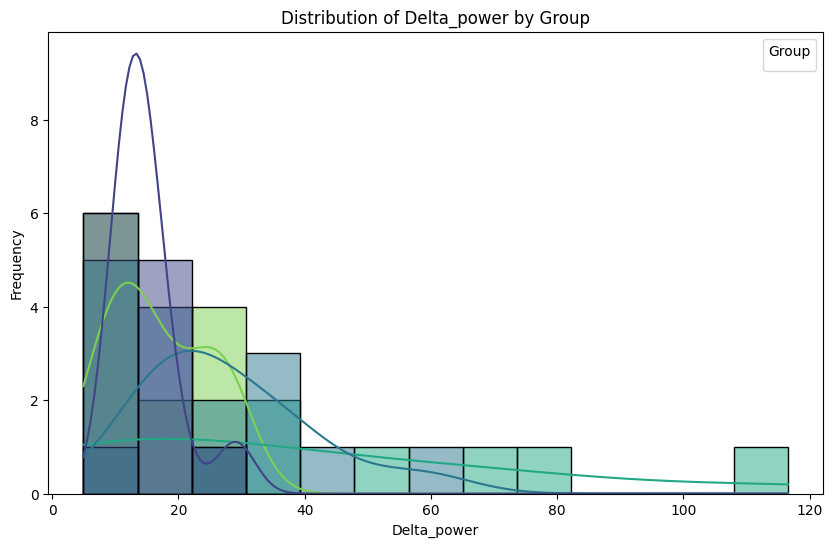

No handles with labels found to put in legend.


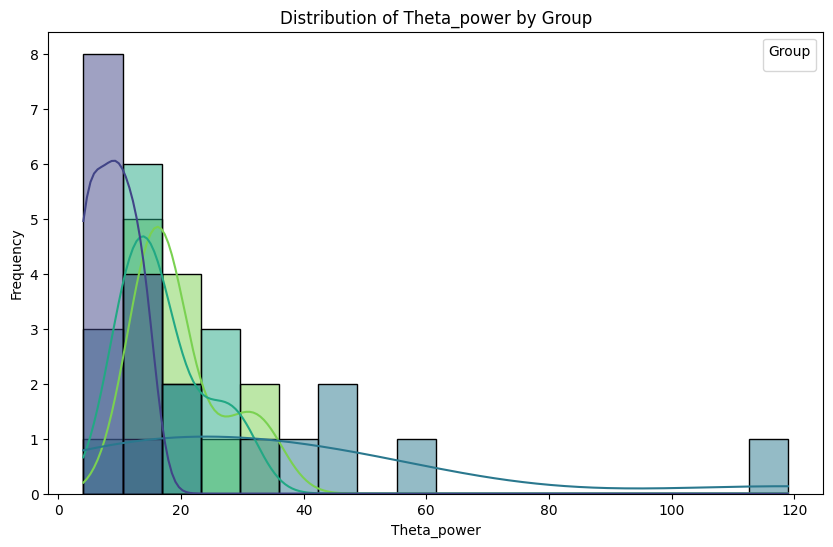

No handles with labels found to put in legend.


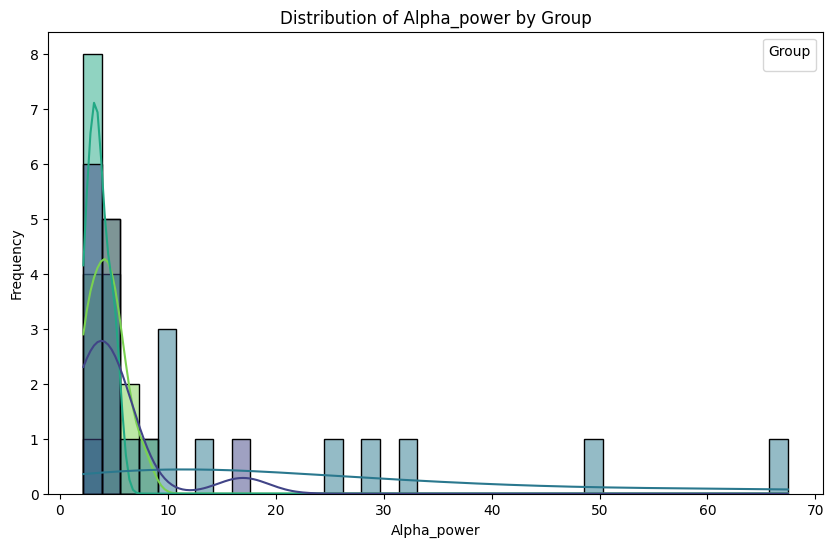

No handles with labels found to put in legend.


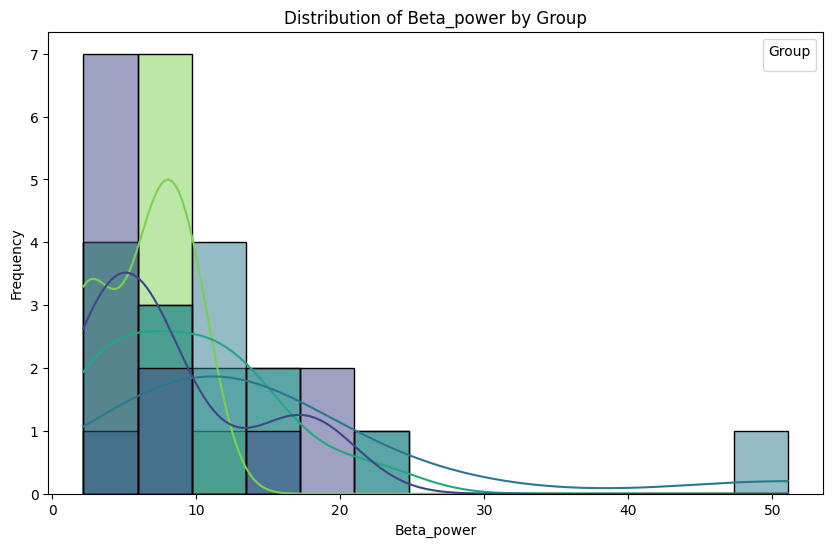

In [19]:
bands = ['delta_power', 'theta_power', 'alpha_power', 'beta_power']
for band in bands:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=all_data, x=band, hue='Group', kde=True, palette='viridis')
    plt.title(f'Distribution of {band.capitalize()} by Group')
    plt.xlabel(f'{band.capitalize()}')
    plt.ylabel('Frequency')
    plt.legend(title='Group')
    plt.show()

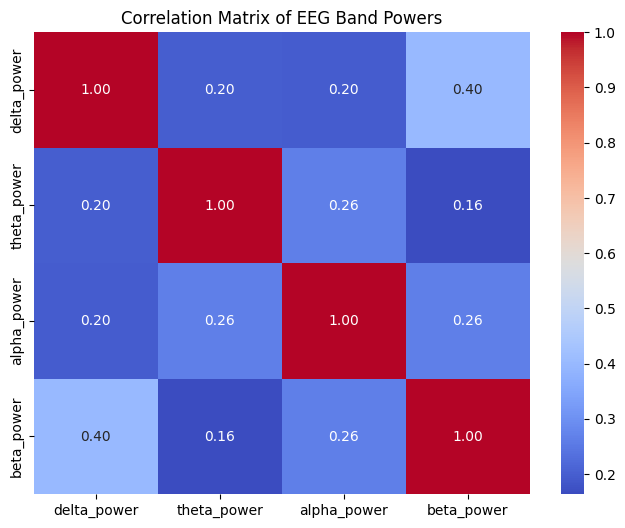

In [20]:
plt.figure(figsize=(8, 6))
sns.heatmap(all_data[bands].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of EEG Band Powers")
plt.show()

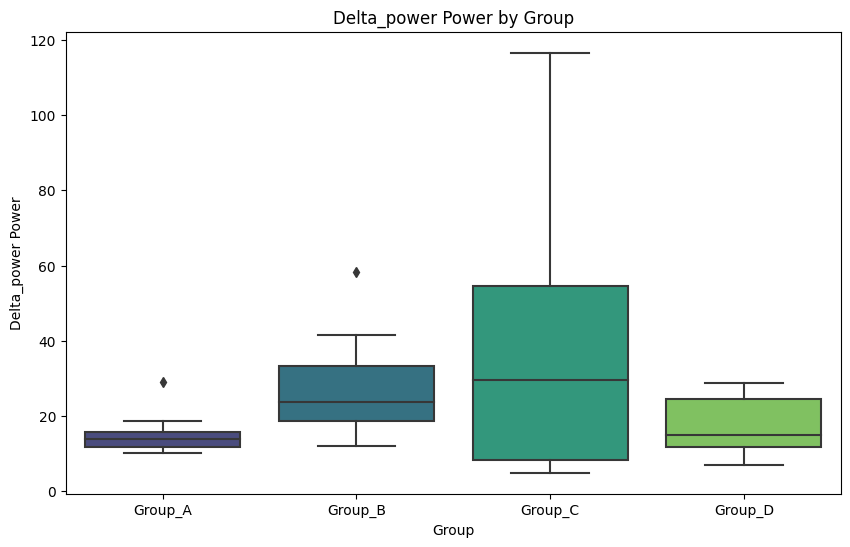

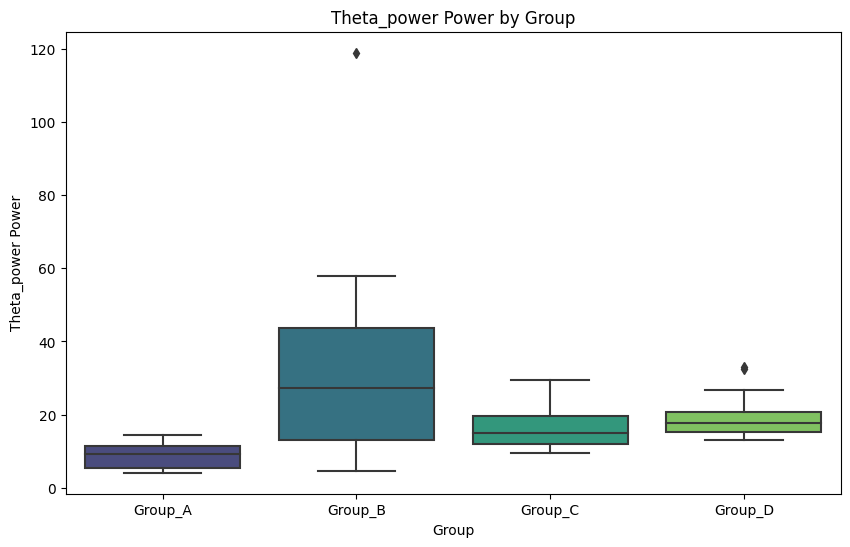

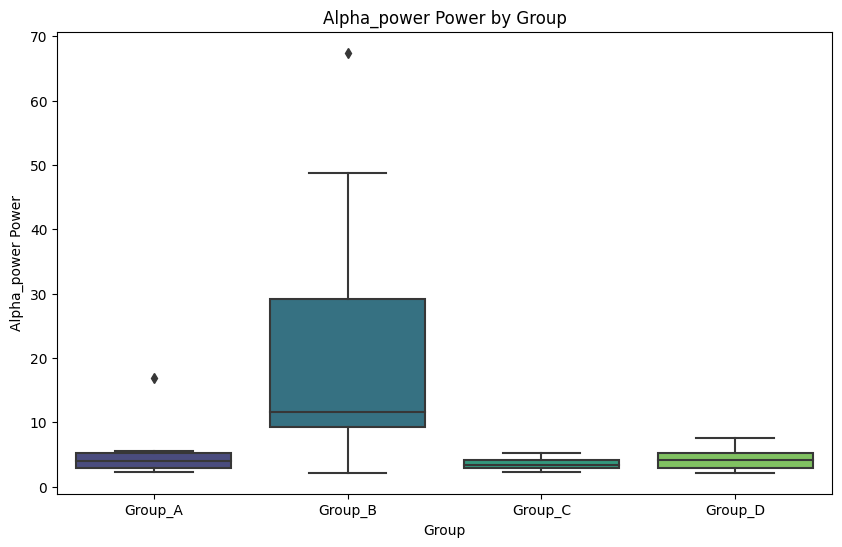

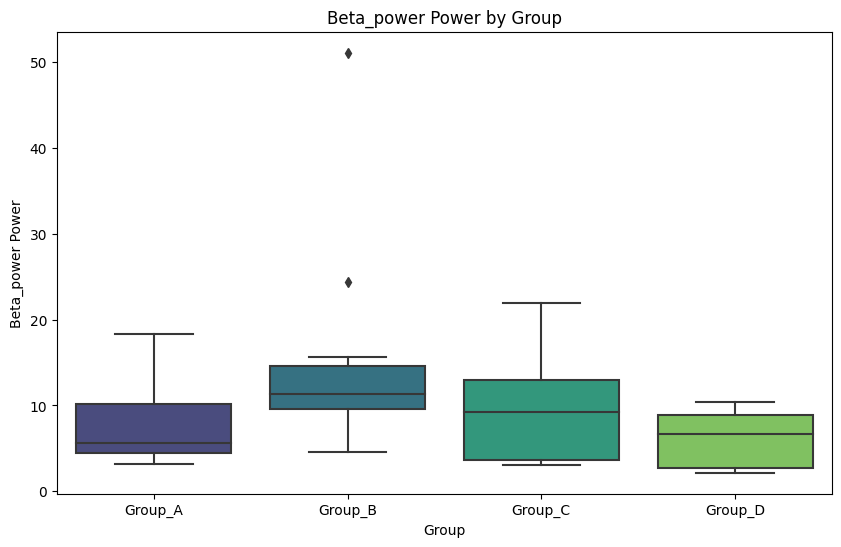

In [21]:
for band in bands:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=all_data, x='Group', y=band, palette='viridis')
    plt.title(f'{band.capitalize()} Power by Group')
    plt.xlabel('Group')
    plt.ylabel(f'{band.capitalize()} Power')
    plt.show()

### 3. Model

In [22]:
# Encode target labels for AD prediction
all_data['Label'] = all_data['Group'].apply(lambda x: 1 if x in ['Group_C', 'Group_D'] else 0)  # 1 = AD, 0 = Healthy
X = all_data.drop(['Group', 'Label'], axis=1)
y = all_data['Label']

In [23]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
rf_pipeline = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))
])

# XGBoost pipeline (with scaling)
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# SVM pipeline (with scaling)
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))
])

In [25]:
pipelines = {
    'Random Forest': rf_pipeline,
    'XGBoost': xgb_pipeline,
    'SVM': svm_pipeline
}

In [26]:
# Cross-validation scores for each model
cv_scores = {}
for model_name, pipeline in pipelines.items():
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores[model_name] = scores.mean()
    print(f"{model_name} Cross-Validation Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")

Random Forest Cross-Validation Accuracy: 0.8714 (+/- 0.1371)
XGBoost Cross-Validation Accuracy: 0.8750 (+/- 0.1369)
SVM Cross-Validation Accuracy: 0.8393 (+/- 0.1010)


In [27]:
# Choose the best model based on cross-validation performance
best_model_name = max(cv_scores, key=cv_scores.get)
print(f"\nBest model based on cross-validation: {best_model_name}")


Best model based on cross-validation: XGBoost


In [28]:
# Train the best model on the full training set and evaluate on the test set
best_pipeline = pipelines[best_model_name]
best_pipeline.fit(X_train, y_train)
y_test_pred = best_pipeline.predict(X_test)

In [29]:
# Final evaluation metrics on the test set
print("\nFinal Evaluation on Test Set:")
print(classification_report(y_test, y_test_pred))
print("Test Set Accuracy:", accuracy_score(y_test, y_test_pred))


Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       1.00      0.71      0.83         7

    accuracy                           0.80        10
   macro avg       0.80      0.86      0.79        10
weighted avg       0.88      0.80      0.81        10

Test Set Accuracy: 0.8


<Figure size 800x600 with 0 Axes>

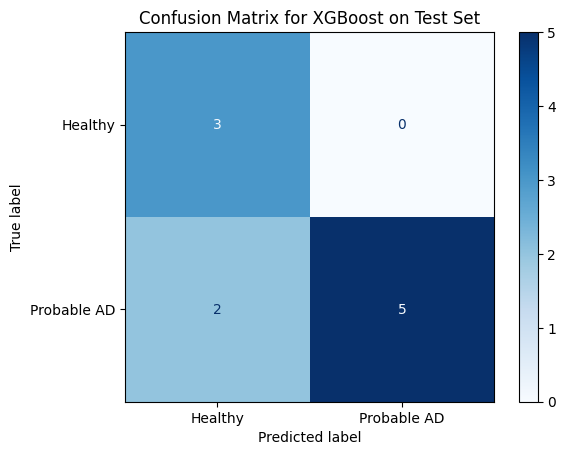

In [30]:
# Generate confusion matrix for the test set predictions
conf_matrix = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Healthy", "Probable AD"])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix for {best_model_name} on Test Set")
plt.show()